In [1]:
import numpy as np
#import json
import os
import logging
import sys
import copy
import open3d as o3d
import itertools
import torch
import gc
import psutil
import datetime
import networkx as nx
import cv2
import gym

from gibson2.utils.utils import parse_config, dist
from gibson2.utils.utils import parse_config, dist, cartesian_to_polar
from gibson2.utils.mesh_util import xyzw2wxyz, quat2rotmat
from transforms3d.euler import euler2quat 
from gibson2.envs.igibson_env import iGibsonEnv
from SAC.SAC import SAC
from torch.utils.tensorboard import SummaryWriter
from SAC.replay_memory import ReplayMemory
from occupancy_grid.occupancy_grid import create_occupancy_grid, get_closest_free_space_to_robot, \
    a_star_search, update_map, get_robot_pos_on_grid, fill_invisible_cells_close_to_the_robot, \
    visualize_occupancy_grid, visualize_path, get_turn_angle, inflate_grid
from point_cloud.point_cloud import get_point_clouds, get_min_max_pcd
from frontier.frontier import get_frontiers, show_frontiers
from matplotlib import pyplot as plt
from gibson2.utils.constants import *
from encoder.obs_encoder import ObsEncoder
from PIL import Image
import pickle

logging.getLogger().setLevel(logging.WARNING)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO:root:Importing iGibson (gibson2 module)
INFO:root:Assets path: /media/arnab/ExtremeSSD/GMU/Study/Semester9_Fall22/research/social_navigation/iGibson/gibson2/data/gibson_challenge_data_2021/assets
INFO:root:Gibson Dataset path: /media/arnab/ExtremeSSD/GMU/Study/Semester9_Fall22/research/social_navigation/iGibson/gibson2/data/g_dataset
INFO:root:iG Dataset path: /media/arnab/ExtremeSSD/GMU/Study/Semester9_Fall22/research/social_navigation/iGibson/gibson2/data/gibson_challenge_data_2021/ig_dataset
INFO:root:3D-FRONT Dataset path: /media/arnab/ExtremeSSD/GMU/Study/Semester9_Fall22/research/social_navigation/iGibson/gibson2/data/threedfront_dataset
INFO:root:CubiCasa5K Dataset path: /media/arnab/ExtremeSSD/GMU/Study/Semester9_Fall22/research/social_navigation/iGibson/gibson2/data/cubicasa_dataset
INFO:root:Example path: /media/arnab/ExtremeSSD/GMU/Study/Semester9_Fall22/research/social_navigation/iGibson/gibson2/examples
INFO:root:Example config path: /media/arnab/ExtremeSSD/GMU/Study/

In [2]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--agent-class", type=str, default="SAC", choices=["Random", "ForwardOnly", "SAC"])
parser.add_argument("--ckpt-path", default="", type=str)
parser.add_argument('--policy', default="Deterministic",
                    help='Policy Type: Gaussian | Deterministic (default: Gaussian)')
parser.add_argument('--eval', type=bool, default=True,
                    help='Evaluates a policy a policy every 10 episode (default: True)')
parser.add_argument('--gamma', type=float, default=0.99, metavar='G',
                    help='discount factor for reward (default: 0.99)')
parser.add_argument('--tau', type=float, default=0.005, metavar='G',
                    help='target smoothing coefficient(τ) (default: 0.005)')
parser.add_argument('--lr', type=float, default=0.0003, metavar='G',
                    help='learning rate (default: 0.0003)')
parser.add_argument('--alpha', type=float, default=0.2, metavar='G',
                    help='Temperature parameter α determines the relative importance of the entropy\
                            term against the reward (default: 0.2)')
parser.add_argument('--automatic_entropy_tuning', type=bool, default=False, metavar='G',
                    help='Automaically adjust α (default: False)')
parser.add_argument('--seed', type=int, default=123456, metavar='N',
                    help='random seed (default: 123456)')
parser.add_argument('--batch_size', type=int, default=256, metavar='N',
                    help='batch size (default: 256)')
parser.add_argument('--num_steps', type=int, default=10000001, metavar='N',
                    help='maximum number of steps (default: 1000000)')
parser.add_argument('--hidden_size', type=int, default=256, metavar='N',
                    help='hidden size (default: 256)')
parser.add_argument('--updates_per_step', type=int, default=1, metavar='N',
                    help='model updates per simulator step (default: 1)')
parser.add_argument('--start_steps', type=int, default=10000, metavar='N',
                    help='Steps sampling random actions (default: 10000)')
parser.add_argument('--target_update_interval', type=int, default=1, metavar='N',
                    help='Value target update per no. of updates per step (default: 1)')
parser.add_argument('--replay_size', type=int, default=1000000, metavar='N',
                    help='size of replay buffer (default: 10000000)')
parser.add_argument('--cuda', action="store_false",
                    help='run on CUDA (default: True)')
parser.add_argument("--device", default='cuda')
parser.add_argument('--obs_goal', type=bool, default=True)
parser.add_argument('--obs_waypoints', type=bool, default=True)
parser.add_argument('--obs_map', type=bool, default=True)
parser.add_argument('--feature_dim', type=int, default=256)
parser.add_argument('--num_wps_input', type=int, default=6)

parser.add_argument('--load_checkpoint', type=bool, default=True)
parser.add_argument('--checkpoint_path', type=str, default="checkpoints/sac_checkpoint_deterministic_polar_potential0.1_orientation0.01_threshold0.1")
parser.add_argument('--checkpoint_name', type=str, default="current_polar_potential0.01orientation0.001")

parser.add_argument('--load_checkpoint_memory', type=bool, default=True)
parser.add_argument('--checkpoint_path_memory', type=str, default="checkpoints/sac_buffer_deterministic_polar_potential0.1_orientation0.01_threshold0.1_memory")
parser.add_argument('--checkpoint_name_memory', type=str, default="current_polar_potential0.01orientation0.001_memory")
args = parser.parse_args(args=[])

In [3]:
config_file = CONFIG_FILE
split = SPLIT
episode_dir = EPISODE_DIR
eval_episodes_per_scene = 100

train_scenes = ['Beechwood_1_int', 'Benevolence_0_int', 'Ihlen_1_int', 'Wainscott_1_int']
val_scenes = ['Ihlen_0_int']
test_scenes = ['Merom_0_int', 'Rs_int']

In [4]:
def build_traversibility_graph(scene_id):
    path = f'gibson2/data/gibson_challenge_data_2021/ig_dataset/scenes/{scene_id}/layout/trav_graph.pickle'
    if not os.path.exists(path):
        img_path = f'gibson2/data/gibson_challenge_data_2021/ig_dataset/scenes/{scene_id}/layout/floor_trav_0_new.png'
        img = Image.open(img_path)
        occupancy_grid = np.array(img)
        occupancy_grid[occupancy_grid!=0] = 1
        inflated_grid = inflate_grid(occupancy_grid, 3, 0, 0)
        graph = nx.grid_graph((inflated_grid.shape[0], inflated_grid.shape[1]))
        nx.set_edge_attributes(graph, np.inf, "cost")

        free_space = np.vstack((np.where(inflated_grid==1)[0], np.where(inflated_grid==1)[1])).T
        free_space_nodes = tuple(map(tuple, free_space))
        free_space_nodes = {node:None for node in free_space_nodes}

        cost = {}
        for edge in graph.edges():
            if edge[0] in free_space_nodes and edge[1] in free_space_nodes:
                cost[edge] = np.linalg.norm(np.array(edge[0])-np.array(edge[1]))
        nx.set_edge_attributes(graph, cost, "cost")

        pickle.dump(graph, open(path, 'wb'))
    else:
        graph = pickle.load(open(path, 'rb'))

    return graph

In [5]:
def get_waypoints(scene_id, env):
    graph_path = f'gibson2/data/gibson_challenge_data_2021/ig_dataset/scenes/{scene_id}/layout/trav_graph.pickle'
    graph = pickle.load(open(graph_path, 'rb'))

    source = env.scene.world_to_seg_map(env.robots[0].get_position()[:-1])
    target = env.scene.world_to_seg_map(env.task.target_pos[:-1])

    path = nx.astar_path(graph, tuple(source), tuple(target), heuristic=dist, weight="cost")
    #path = path[1:]
    point_interval = 5
    p = path[::point_interval][1:]

    if tuple(target) not in p:
        p.append(tuple(target))
    #return p
    
    return list(map(env.scene.seg_map_to_world,map(np.array, p)))

In [7]:
def visualize_path(occupancy_grid, path, store=False, show=False, output_path=None):
    plt.figure(figsize=[12,12])
    for i in path:
        plt.plot(i[1], i[0], marker="o", markersize=2, alpha=0.8)
    plt.imshow(occupancy_grid, cmap='gray'); 
    if show == True:
        plt.show()
    if store == True:
        plt.savefig(output_path)

In [12]:
env_config = parse_config(config_file)
val_env_config = parse_config(config_file)
torch.manual_seed(args.seed)
np.random.seed(args.seed)

task = env_config['task']
if task == 'interactive_nav_random':
    metrics = {key: 0.0 for key in [
        'success', 'spl', 'effort_efficiency', 'ins', 'episode_return']}
elif task == 'social_nav_random':
    metrics = {key: 0.0 for key in [
        'success', 'stl', 'psc', 'episode_return']}
else:
    assert False, 'unknown task: {}'.format(task)

# Make action space as a gym box
low = np.array([-1,-1])
high = np.array([1,1])
action_space = gym.spaces.Box(low, high, dtype=np.float32)

agent = SAC(num_inputs=256, action_space=action_space, args=args)
if args.load_checkpoint == True:
    agent.load_checkpoint(ckpt_path=args.checkpoint_path)
obs_encoder = ObsEncoder(args).to(args.device)
writer = SummaryWriter('runs/{}_SAC_{}_{}'.format(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"),
                                                            args.policy, "autotune" if args.automatic_entropy_tuning else ""))
memory = ReplayMemory(args.replay_size, args.seed)

num_episodes_per_scene = eval_episodes_per_scene
split_dir = os.path.join(episode_dir, split)
assert os.path.isdir(split_dir)
num_scenes = len(os.listdir(split_dir))
assert num_scenes > 0
total_num_episodes = num_scenes * num_episodes_per_scene

# Intialize eval scene
val_scene_id = val_scenes[0]
json_file = os.path.join(split_dir, f'{val_scene_id}.json')
val_env_config['scene_id'] = val_scene_id
val_env_config['load_scene_episode_config'] = False
val_env_config['scene_episode_config_name'] = json_file
val_env = iGibsonEnv(config_file=val_env_config,
                    mode='headless',
                    action_timestep=1.0 / 10.0,
                    physics_timestep=1.0 / 40.0)

build_traversibility_graph(val_scene_id)

total_numsteps = 0
updates = 0
epoch = 0
total_num_episodes = 0
highest_reward = -np.inf
end = False

/media/arnab/ExtremeSSD/GMU/Study/Semester9_Fall22/research/social_navigation/igibson/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Loading models from checkpoints/sac_checkpoint_current_polar_reversedone_
Compiling GLSL shader: /media/arnab/ExtremeSSD/GMU/Study/Semester9_Fall22/research/social_navigation/iGibson/gibson2/render/mesh_renderer/shaders/450/equirect2cube_cs.glsl
Compiling GLSL shader: /media/arnab/ExtremeSSD/GMU/Study/Semester9_Fall22/research/social_navigation/iGibson/gibson2/render/mesh_renderer/shaders/450/spmap_cs.glsl
Compiling GLSL shader: /media/arnab/ExtremeSSD/GMU/Study/Semester9_Fall22/research/social_navigation/iGibson/gibson2/render/mesh_renderer/shaders/450/irmap_cs.glsl
Compiling GLSL shader: /media/arnab/ExtremeSSD/GMU/Study/Semester9_Fall22/research/social_navigation/iGibson/gibson2/render/mesh_renderer/shaders/450/spbrdf_cs.glsl
Loading image: /media/arnab/ExtremeSSD/GMU/Study/Semester9_Fall22/research/social_navigation/iGibson/gibson2/data/gibson_challenge_data_2021/ig_dataset/scenes/background/photo_studio_01_2k.hdr
INFO: compiled pbr shaders
******************PyBullet Logging Inform

add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
a

add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
a

add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
a

add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node


In [6]:
low = np.array([-1,-1])
high = np.array([1,1])
action_space = gym.spaces.Box(low, high, dtype=np.float32)

agent = SAC(num_inputs=256, action_space=action_space, args=args)
if args.load_checkpoint == True:
    agent.load_checkpoint(ckpt_path=args.checkpoint_path, evaluate=True)
obs_encoder = ObsEncoder(args).to(args.device)
writer = SummaryWriter('runs/{}_SAC_{}_{}'.format(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"),
                                                            args.policy, "autotune" if args.automatic_entropy_tuning else ""))
memory = ReplayMemory(args.replay_size, args.seed)
if args.load_checkpoint_memory == True:
    memory.load_buffer(save_path=args.checkpoint_path_memory)

epoch = 0
split_dir = os.path.join(episode_dir, split)
env_config = parse_config(config_file)
scene_id = train_scenes[epoch%len(train_scenes)]
json_file = os.path.join(split_dir, f'{scene_id}.json')
env_config['scene_id'] = scene_id
env_config['load_scene_episode_config'] = False
env_config['scene_episode_config_name'] = json_file
env = iGibsonEnv(config_file=env_config,
                 mode='headless',
                 action_timestep=1.0 / 10.0,
                 physics_timestep=1.0 / 40.0)

build_traversibility_graph(scene_id)

/media/arnab/ExtremeSSD/GMU/Study/Semester9_Fall22/research/social_navigation/igibson/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Loading models from checkpoints/sac_checkpoint_deterministic_polar_potential0.1_orientation0.01_threshold0.1


2023-09-01 16:09:08.664863: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /media/arnab/ExtremeSSD/GMU/Study/Semester9_Fall22/research/social_navigation/igibson/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-8.0/lib64:/home/arnab/.mujoco/mujoco210/bin:/usr/lib/nvidia
2023-09-01 16:09:08.664925: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Loading buffer from checkpoints/sac_buffer_deterministic_polar_potential0.1_orientation0.01_threshold0.1_memory
Compiling GLSL shader: /media/arnab/ExtremeSSD/GMU/Study/Semester9_Fall22/research/social_navigation/iGibson/gibson2/render/mesh_renderer/shaders/450/equirect2cube_cs.glsl
Compiling GLSL shader: /media/arnab/ExtremeSSD/GMU/Study/Semester9_Fall22/research/social_navigation/iGibson/gibson2/render/mesh_renderer/shaders/450/spmap_cs.glsl
Compiling GLSL shader: /media/arnab/ExtremeSSD/GMU/Study/Semester9_Fall22/research/social_navigation/iGibson/gibson2/render/mesh_renderer/shaders/450/irmap_cs.glsl
Compiling GLSL shader: /media/arnab/ExtremeSSD/GMU/Study/Semester9_Fall22/research/social_navigation/iGibson/gibson2/render/mesh_renderer/shaders/450/spbrdf_cs.glsl
Loading image: /media/arnab/ExtremeSSD/GMU/Study/Semester9_Fall22/research/social_navigation/iGibson/gibson2/data/gibson_challenge_data_2021/ig_dataset/scenes/background/photo_studio_01_2k.hdr
INFO: compiled pbr shaders
***

add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
a

add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
a

add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
add_node
a

/media/arnab/ExtremeSSD/GMU/Study/Semester9_Fall22/research/social_navigation/iGibson/gibson2/render/mesh_renderer/mesh_renderer_cpu.py:460: RuntimeWarning: divide by zero encountered in true_divide
  r = 1.0 / (delta_uv1[:, 0] * delta_uv2[:, 1] -
/media/arnab/ExtremeSSD/GMU/Study/Semester9_Fall22/research/social_navigation/iGibson/gibson2/render/mesh_renderer/mesh_renderer_cpu.py:462: RuntimeWarning: invalid value encountered in multiply
  tangent = (delta_pos1 * delta_uv2[:, 1][:, None] -
/media/arnab/ExtremeSSD/GMU/Study/Semester9_Fall22/research/social_navigation/iGibson/gibson2/render/mesh_renderer/mesh_renderer_cpu.py:464: RuntimeWarning: invalid value encountered in multiply
  bitangent = (delta_pos2 * delta_uv1[:, 0][:, None] -


In [13]:
state = env.reset()
print(env.robots[0].get_position())
print(env.task.target_pos)

[-5.23770905 -5.91866446  0.3372348 ]
[-5.7 -0.9  0. ]


In [8]:
def get_point_clouds(env, visualize=False, mode="robot_coordinate"):
    eye_pos, eye_orn = env.robots[0].eyes.get_position(), env.robots[0].eyes.get_orientation()
    camera_in_wf = quat2rotmat(xyzw2wxyz(eye_orn))
    camera_in_wf[:3,3] = eye_pos

    # Transforming coordinates of points from opengl frame to camera frame
    camera_in_openglf = quat2rotmat(euler2quat(np.pi / 2.0, 0, -np.pi / 2.0))

    # Pose of the simulated robot in world frame
    robot_pos, robot_orn = env.robots[0].get_position(), env.robots[0].get_orientation()
    robot_in_wf = quat2rotmat(xyzw2wxyz(robot_orn))
    robot_in_wf[:3, 3] = robot_pos

    # Pose of the camera in robot frame
    cam_in_robot_frame = np.dot(np.linalg.inv(robot_in_wf), camera_in_wf)

    [td_image] = env.simulator.renderer.render(modes=('3d'))
    point_in_cf = np.dot(td_image.reshape(-1,4), camera_in_openglf.T)
    point_in_rf = np.dot(point_in_cf,cam_in_robot_frame.T)
    pcd_distance = np.linalg.norm(point_in_rf, axis=1)
    point_in_rf = point_in_rf[pcd_distance <= 10]
    point_in_wf = np.dot(point_in_rf, robot_in_wf.T)
    
    
    #pcd = pcd.voxel_down_sample(voxel_size=0.05)

    #pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    if visualize == True:
        visualize_np_point_cloud(point_in_wf[:,[0,1,2]])
    #np.save('test_pc_3', point_in_wf[:,[0,1,2]])
    if mode == "world_coordinate":
        return point_in_wf[:,[0,1,2]]
    if mode == "robot_coordinate":
        return point_in_rf[:, [0,1,2]]

In [20]:
def get_local_map(env):
    #pc,_ = get_point_clouds(env, visualize=False)
    pc,_ = get_point_clouds(env, visualize=False)
    pc = np.vstack((pc, env.robots[0].get_position()))
    min_x,max_x,min_y,max_y,min_z,max_z = get_min_max_pcd(pc)

    robot_position_wc = env.robots[0].get_position()
    occupancy_grid, robot_pos, goal_pos = create_occupancy_grid([pc],min_x,max_x,min_y,max_y,min_z,max_z, \
        robot_position_wc, goal_pos=env.task.target_pos, RESOLUTION = RESOLUTION, visualize=False, index=None, output_dir=None)
    #occupancy_grid = inflate_grid(occupancy_grid, 2, 0, 0)
    #occupancy_grid = fill_invisible_cells_close_to_the_robot(occupancy_grid, robot_pos[1], robot_pos[0])
    robot_footprint_radius = 0.32
    robot_footprint_radius_map = int(robot_footprint_radius/RESOLUTION)
    #plt.figure()
    #plt.imshow(occupancy_grid,cmap='gray')
    cv2.circle(img=occupancy_grid, center=robot_pos[::-1], radius=robot_footprint_radius_map,color=1, thickness=-1)
    
    #plt.figure()
    #plt.imshow(occupancy_grid,cmap='gray')
    #occupancy_grid = cv2.resize(occupancy_grid, (100,100))
    mask_grid_size = (224,224)
    occupancy_grid_mask = np.ones(mask_grid_size)*0.5
    i_x = int(mask_grid_size[0]/2)-robot_pos[0]
    i_y = int(mask_grid_size[1]/2)-robot_pos[1]
    try:
       occupancy_grid_mask[i_x:i_x+occupancy_grid.shape[0],i_y:i_y+occupancy_grid.shape[1]] = occupancy_grid
    except:
       print(occupancy_grid.shape)
       plt.imshow(occupancy_grid,cmap='gray'); plt.show()
       print(robot_pos)
    occupancy_grid = occupancy_grid_mask
    
    #plt.figure()
    #plt.imshow(occupancy_grid,cmap='gray')

    return occupancy_grid

In [7]:
def get_local_map(env):
    # Get point cloud in robot coordinate frame
    pc = get_point_clouds(env, visualize=False, mode="robot_coordinate")
    pc = np.vstack((pc, np.array([0,0,0]))) #Add robot position
    min_x,max_x,min_y,max_y,min_z,max_z = get_min_max_pcd(pc)

    robot_position_wc = env.robots[0].get_position()
    occupancy_grid, robot_pos, goal_pos = create_occupancy_grid([pc],min_x,max_x,min_y,max_y,min_z,max_z, \
        robot_position_wc, goal_pos=env.task.target_pos, RESOLUTION = RESOLUTION, visualize=False, index=None,\
              output_dir=None, mode="robot_coordinate")
    #occupancy_grid = inflate_grid(occupancy_grid, 2, 0, 0)
    #occupancy_grid = fill_invisible_cells_close_to_the_robot(occupancy_grid, robot_pos[1], robot_pos[0])

    # Add robot footprint
    robot_footprint_radius = 0.32
    robot_footprint_radius_map = int(robot_footprint_radius/RESOLUTION)
    cv2.circle(img=occupancy_grid, center=robot_pos[::-1], radius=robot_footprint_radius_map,color=1, thickness=-1)
    
    # Plot og
    #plt.figure()
    #plt.imshow(occupancy_grid,cmap='gray')
    #plt.xlabel('occupancy grid rf')

    # Align occupancy grid in a larger matrix of size (224,224)
    mask_grid_size = (224,224)
    occupancy_grid_mask = np.ones(mask_grid_size)*0.5
    i_x = int(mask_grid_size[0]/2)-robot_pos[0]
    i_y = int(mask_grid_size[1]/2)-robot_pos[1]
    try:
        occupancy_grid_mask[i_x:i_x+occupancy_grid.shape[0],i_y:i_y+occupancy_grid.shape[1]] = occupancy_grid
    except:
        print(occupancy_grid.shape)
        plt.imshow(occupancy_grid); plt.show()
        print(robot_pos)
    occupancy_grid = occupancy_grid_mask
    
    # plot og
    #plt.figure()
    #plt.imshow(occupancy_grid,cmap='gray')
    #plt.xlabel('occupancy grid rf')

    return occupancy_grid

In [22]:
'''
Test for occupancy grid in robot frame
'''
def get_local_map_rf_test(env):
    # WORLD CF
    # Get point cloud in world coordinate frame
    pc_wf = get_point_clouds(env, visualize=False, mode="world_coordinate")
    robot_position_wc = env.robots[0].get_position()
    pc_wf = np.vstack((pc_wf, robot_position_wc)) # Add robot current position
    min_x_wf,max_x_wf,min_y_wf,max_y_wf,min_z_wf,max_z_wf = get_min_max_pcd(pc_wf)
    print("min_x_wf,max_x_wf,min_y_wf,max_y_wf,min_z_wf,max_z_wf", min_x_wf,max_x_wf,min_y_wf,max_y_wf,min_z_wf,max_z_wf)

    # Create occupancy grid
    occupancy_grid, robot_pos, goal_pos = create_occupancy_grid([pc_wf],min_x_wf,max_x_wf,min_y_wf,max_y_wf,\
        min_z_wf,max_z_wf, robot_position_wc, goal_pos=env.task.target_pos, RESOLUTION = RESOLUTION, \
        visualize=False, index=None, output_dir=None, mode="world_coordinate")
    #occupancy_grid = inflate_grid(occupancy_grid, 2, 0, 0)
    #occupancy_grid = fill_invisible_cells_close_to_the_robot(occupancy_grid, robot_pos[1], robot_pos[0])
    robot_footprint_radius = 0.32
    robot_footprint_radius_map = int(robot_footprint_radius/RESOLUTION)
    
    # plot og in world coordinate frame
    plt.figure()
    plt.imshow(occupancy_grid,cmap='gray')
    plt.xlabel('occupancy grid wf')
    cv2.circle(img=occupancy_grid, center=robot_pos[::-1], radius=robot_footprint_radius_map,color=1, thickness=-1)
    
    #plt.figure()
    #plt.imshow(occupancy_grid,cmap='gray')
    #occupancy_grid = cv2.resize(occupancy_grid, (100,100))
    
    # Align occupancy grid in a larger matrix of size (224,224)
    mask_grid_size = (224,224)
    occupancy_grid_mask = np.ones(mask_grid_size)*0.5
    i_x = int(mask_grid_size[0]/2)-robot_pos[0]
    i_y = int(mask_grid_size[1]/2)-robot_pos[1]
    try:
       occupancy_grid_mask[i_x:i_x+occupancy_grid.shape[0],i_y:i_y+occupancy_grid.shape[1]] = occupancy_grid
    except:
       print(occupancy_grid.shape)
       plt.imshow(occupancy_grid,cmap='gray'); plt.show()
       #print(robot_pos)
    occupancy_grid = occupancy_grid_mask
    
    
    # plot og in larger size
    plt.figure()
    plt.imshow(occupancy_grid,cmap='gray')
    plt.xlabel('occupancy grid wf')
    
    # ROBOT CF
    # Get point cloud in robot coordinate frame
    pc_rf = get_point_clouds(env, visualize=False, mode="robot_coordinate")
    pc_rf = np.vstack((pc_rf, np.array([0,0,0])))
    min_x_rf,max_x_rf,min_y_rf,max_y_rf,min_z_rf,max_z_rf = get_min_max_pcd(pc_rf)
    print("min_x_rf,max_x_rf,min_y_rf,max_y_rf,min_z_rf,max_z_rf", min_x_rf,max_x_rf,min_y_rf,max_y_rf,min_z_rf,max_z_rf)
    
    occupancy_grid, robot_pos, goal_pos = create_occupancy_grid([pc_rf],min_x_rf,max_x_rf,min_y_rf,max_y_rf,\
        min_z_rf,max_z_rf, robot_position_wc, goal_pos=env.task.target_pos, RESOLUTION = RESOLUTION, \
        visualize=False, index=None, output_dir=None, mode="robot_coordinate")
    #occupancy_grid = inflate_grid(occupancy_grid, 2, 0, 0)
    #occupancy_grid = fill_invisible_cells_close_to_the_robot(occupancy_grid, robot_pos[1], robot_pos[0])
    robot_footprint_radius = 0.32
    robot_footprint_radius_map = int(robot_footprint_radius/RESOLUTION)
    
    # plot og
    plt.figure()
    plt.imshow(occupancy_grid,cmap='gray')
    plt.xlabel('occupancy grid rf')
    cv2.circle(img=occupancy_grid, center=robot_pos[::-1], radius=robot_footprint_radius_map,color=1, thickness=-1)
    
    #plt.figure()
    #plt.imshow(occupancy_grid,cmap='gray')
    #occupancy_grid = cv2.resize(occupancy_grid, (100,100))
    mask_grid_size = (224,224)
    occupancy_grid_mask = np.ones(mask_grid_size)*0.5
    i_x = int(mask_grid_size[0]/2)-robot_pos[0]
    i_y = int(mask_grid_size[1]/2)-robot_pos[1]
    try:
       occupancy_grid_mask[i_x:i_x+occupancy_grid.shape[0],i_y:i_y+occupancy_grid.shape[1]] = occupancy_grid
    except:
       print(occupancy_grid.shape)
       plt.imshow(occupancy_grid,cmap='gray'); plt.show()
       #print(robot_pos)
    occupancy_grid = occupancy_grid_mask
    #occupancy_grid = fill_invisible_cells_close_to_the_robot(occupancy_grid, robot_pos[1], robot_pos[0])
    
    plt.figure()
    plt.imshow(occupancy_grid,cmap='gray')
    plt.xlabel('occupancy grid rf')

    return occupancy_grid

In [35]:
def create_occupancy_grid(current_pcds,min_x,max_x,min_y,max_y,min_z,max_z, \
                          robot_position, goal_pos, RESOLUTION = 0.05, visualize=True, \
                            index=None, output_dir=None, mode="world_coordinate"):
    x_range = int((max_x - min_x) / RESOLUTION)
    y_range = int((max_y - min_y) / RESOLUTION)
    z_range = int((max_z - min_z) / RESOLUTION)
    
    if mode == "world_coordinate":
        THRESHOLD_LOW = 0.1
    elif mode == "robot_coordinate":
        THRESHOLD_LOW = 0.2
    THRESHOLD_HIGH = 1
    #THRESHOLD_LOW = min_z + 0.1
    #THRESHOLD_HIGH = max_y - (max_y-min_y)*0.35
    #THRESHOLD_HIGH = min_y + (max_y-min_y)*0.65
    #THRESHOLD_HIGH = min_z + 0.5
    
    occupancy_grid = np.ones((y_range+1, x_range+1)) * 0.5 #unexlpored
    for i,pcd in enumerate(current_pcds):
        #pc_points = (np.asarray(pcd.points) * scale) + current_point
        #o3d.visualization.draw_geometries([pcd])
        pc_points = pcd

        #l1.append(pcd)

        x = ((pc_points[:,0] - min_x) / RESOLUTION).astype(int)
        y = ((pc_points[:,1] - min_y) / RESOLUTION).astype(int)
        obj = np.logical_and(THRESHOLD_LOW < pc_points[:,2], pc_points[:,2] < THRESHOLD_HIGH)
        free_space = pc_points[:,2] <= THRESHOLD_LOW

        occupancy_grid[y[free_space], x[free_space]] = 1 #freespace = 0
        occupancy_grid[y[obj],x[obj]] = 0 #occupied = 1

        goal_x, goal_y = ((goal_pos[0] - min_x) / RESOLUTION).astype(int), ((goal_pos[1] - min_y) / RESOLUTION).astype(int)
        if mode == "robot_coordinate":
            robot_x, robot_y = ((0 - min_x) / RESOLUTION).astype(int), ((0 - min_y) / RESOLUTION).astype(int)
        if mode == "world_coordinate":
            robot_x, robot_y = ((robot_position[0] - min_x) / RESOLUTION).astype(int), ((robot_position[1] - min_y) / RESOLUTION).astype(int)
            if index == 0:
                occupancy_grid[goal_y][goal_x] = 0.5
        for i in range(-3,4):
            for j in range(-3,4):
                try:
                    occupancy_grid[robot_y+i][robot_x+j] = 0.5
                except:
                    pass
        #occupancy_grid = fill_invisible_cells_close_to_the_robot(occupancy_grid, robot_x, robot_y)
        

        if visualize == True:            
            visualize_occupancy_grid(occupancy_grid, (robot_x, robot_y), (goal_x, goal_y), store=True, show=False, output_path=f'{output_dir}/og/{index}')
        
        if mode == "world_coordinate":
            np.save(f'pc/pc_obj_wc', pc_points[obj])
            np.save(f'pc/pc_free_wc', pc_points[free_space])
        
        if mode == "robot_coordinate":
            np.save(f'pc/pc_obj_rc', pc_points[obj])
            np.save(f'pc/pc_free_rc', pc_points[free_space])
        #o3d.visualization.draw_geometries([get_pcd_from_numpy(pc_points[free_space])])
        #l.extend(pc_points)
        #l.extend(pc_points[free_space])
        #l2.extend(pc_points[obj])
        
        '''
        pcd1 = o3d.geometry.PointCloud()
        pcd1.points = o3d.utility.Vector3dVector(current_pcds[0])
        o3d.visualization.draw_geometries([pcd1])

        pcd3 = o3d.geometry.PointCloud()
        pcd3.points = o3d.utility.Vector3dVector(pc_points[free_space])
        o3d.visualization.draw_geometries([pcd3])

        pcd2 = o3d.geometry.PointCloud()
        pcd2.points = o3d.utility.Vector3dVector(pc_points[obj])
        o3d.visualization.draw_geometries([pcd2])
        '''
    #o3d.visualization.draw_geometries(current_pcds)    
    #o3d.visualization.draw_geometries([get_pcd_from_numpy(np.array(l))])
    #o3d.visualization.draw_geometries([get_pcd_from_numpy(np.array(l2))])
    
    return occupancy_grid, (robot_y, robot_x), (goal_y, goal_x)

In [8]:
def get_observation(env, state, scene_id, obs_encoder, mode="polar"):
    #task_obs = torch.tensor(state['task_obs']) # relative goal position, orientation, linear and angular velocity
    if mode == "cartesian":
        task_obs = torch.tensor(env.task.target_pos[:-1] - env.robots[0].get_position()[:-1])
    else:
        task_obs = torch.tensor(state['task_obs'][:4]) # relative goal position, orientation, linear and angular velocity

    # Get waypoints
    waypoints = env.waypoints[:args.num_wps_input]
    while len(waypoints) < args.num_wps_input:
        waypoints.append(waypoints[-1])
    if mode == "cartesian":
        waypoints -= env.robots[0].get_position()[:-1]
    else:
        waypoints = np.hstack((waypoints, np.zeros((len(waypoints),1))))
        waypoints_robot_coord = [env.task.global_to_local(env, p)[:2] for p in waypoints]
        # waypoints in polar coordinate in robot frame
        waypoints = [np.array(cartesian_to_polar(p[0],p[1])) for p in waypoints_robot_coord] 

    waypoints = torch.tensor(np.array(waypoints))
    waypoints = waypoints.reshape((-1,))
    #print("waypoints", waypoints)

    map = get_local_map(env)
    map = torch.tensor(map)
    with torch.no_grad():
        encoded_obs = obs_encoder(task_obs.to(args.device).float().unsqueeze(0), \
                    waypoints.to(args.device).float().unsqueeze(0), \
                    map.to(args.device).float())
    encoded_obs = encoded_obs.squeeze(0)
    return encoded_obs.detach().cpu().numpy()

[-2.40719295  1.60520422]
[-3.7 -4.9]


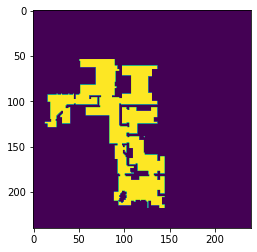

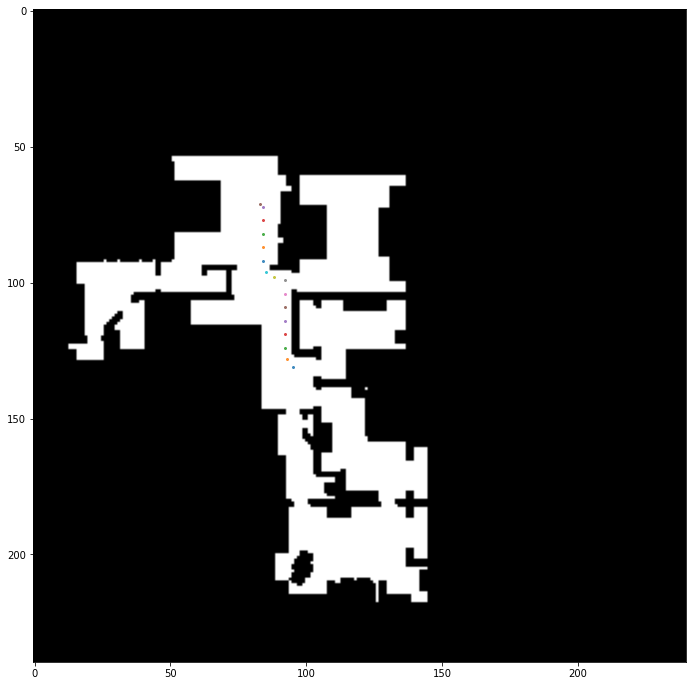

In [15]:
for ep in range(num_episodes_per_scene):
    state = env.reset()
    #plt.imshow(state['rgb']);plt.show()
    env.simulator.sync()
    print(env.robots[0].get_position()[:-1])
    print(env.task.target_pos[:-1])
    
    img_path = f'gibson2/data/gibson_challenge_data_2021/ig_dataset/scenes/{scene_id}/layout/floor_trav_0_new.png'
    img = Image.open(img_path)
    occupancy_grid = np.array(img)
    occupancy_grid[occupancy_grid!=0] = 1
    inflated_grid = inflate_grid(occupancy_grid, 2, 0, 0)
    plt.imshow(occupancy_grid);plt.show()
    
    waypoints = get_waypoints(scene_id, env)
    waypoints_map = list(map(env.scene.world_to_seg_map, waypoints))
    visualize_path(occupancy_grid, waypoints_map, show=True)
    env.waypoints = waypoints
    env.num_wps_input = args.num_wps_input

    episode_reward = 0
    episode_steps = 0
    done = False
    total_distance = 0
    while not done:
        obs = get_observation(env, state, scene_id, obs_encoder)
        robot_prev_pos = env.robots[0].get_position()[:-1]
        if args.start_steps > total_numsteps:
            action = env.action_space.sample()  # Sample random action
        else:
            action = agent.select_action(obs) 
        print("action", action)
        if len(memory) > args.batch_size:
            # Number of updates per step in environment
            for i in range(args.updates_per_step):
                # Update parameters of all the networks
                critic_1_loss, critic_2_loss, policy_loss, ent_loss, alpha = agent.update_parameters(memory, args.batch_size, updates)
                updates += 1
        next_state, reward, done, info = env.step(action) # Step
        next_state_obs = get_observation(env, next_state, scene_id, obs_encoder)
        print("reward", reward)
        
        robot_current_pos = env.robots[0].get_position()[:-1]
        robot_pos = env.scene.world_to_seg_map(env.robots[0].get_position()[:-1])
        plt.figure(figsize=[12,12])
        plt.imshow(occupancy_grid)
        plt.plot(robot_pos[1],robot_pos[0],marker="o", markersize=2, alpha=0.8)
        plt.show()
        
        d = dist(env.robots[0].get_position()[:-1], env.waypoints[0])
        print("distance", d)
        print("waypoints", env.waypoints)
        total_distance += dist(robot_current_pos, robot_prev_pos)
        print()
        
        episode_steps += 1
        total_numsteps += 1
        episode_reward += reward
        
        mask = 1 if episode_steps == env_config['max_step'] else float(not done)

        memory.push(obs, action, reward, next_state_obs, mask) # Append transition to memory

        state = next_state
    print(total_distance)
    break

2.1587989303424644
123.6900675259798
-0.639207246443928
36.62387745541577
87.06619007056403


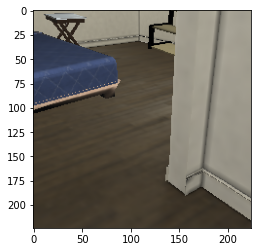

turn angle -1.5195916838985364
-87.06619007056403


In [30]:
p = waypoints[1]*np.array([1,-1]) - waypoints[0]*np.array([1,-1])
angle = np.arctan2(p[1],p[0])
print(angle)
print(np.degrees(angle))
_,_,yaw = env.robots[0].get_rpy()
print(yaw)
print(np.degrees(yaw*-1))
print(np.degrees(angle+yaw))
plt.imshow(state['rgb']);plt.show()
turn_angle = get_turn_angle(angle, yaw)
print("turn angle", turn_angle)
print(np.degrees(turn_angle))

In [52]:
print(state['task_obs'])
robot_pos = env.robots[0].get_position()[:2]
target = env.task.target_pos[:2]
print(robot_pos)
print(target)
print(dist(robot_pos, target))
p = target - robot_pos
angle = np.arctan2(p[1],p[0])
_,_,yaw = env.robots[0].get_rpy()
print(angle)
print(np.degrees(-1.12925736))
print(np.degrees(angle))
print(np.degrees(angle-yaw))
a = env.task.global_to_local(env, env.task.target_pos)[:2]
print(a)
from gibson2.utils.utils import l2_distance, rotate_vector_3d, cartesian_to_polar
print(np.array(cartesian_to_polar(a[0], a[1])))

[ 6.62759764 -1.12925736 -0.14974451  0.02975019]
[-2.40719295  1.60520422]
[-3.7 -4.9]
6.632422791393328
-1.766974549029294
-64.70168071208543
-101.2401841664105
-64.61630671099473
[ 2.83218018 -5.99197846]
[ 6.62759764 -1.12925736]


In [76]:
waypoints = np.array(get_waypoints(scene_id, env))
waypoints = np.hstack((waypoints,np.zeros((len(waypoints),1))))
waypoints_polar = [env.task.global_to_local(env, p)[:2] for p in waypoints]
waypoints_polar = [np.array(cartesian_to_polar(p[0],p[1])) for p in waypoints_polar]
waypoints_polar

[array([ 0.51333129, -1.11451691]),
 array([ 0.85655349, -1.28124987]),
 array([ 1.26713487, -1.24771208]),
 array([ 1.74879727, -1.15934456]),
 array([ 2.23819925, -1.10936042]),
 array([ 2.73118341, -1.07736306]),
 array([ 3.22610797, -1.055166  ]),
 array([ 3.722199 , -1.0388794]),
 array([ 3.88422734, -1.13844924]),
 array([ 4.1494498 , -1.19924074]),
 array([ 4.56143012, -1.19731791]),
 array([ 5.04512132, -1.17150379]),
 array([ 5.53158535, -1.15021783]),
 array([ 6.02015005, -1.13237975]),
 array([ 6.51034252, -1.11722366]),
 array([ 6.62759764, -1.12925736])]

/tmp/ipykernel_5099/3108021108.py:14: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.imshow(occupancy_grid);plt.show()


robot position [0.90001196 5.20481634]
target position [-2.8 -0.2]
distance to the first waypoint 0.5048163415417448


OSError: [Errno 28] No space left on device

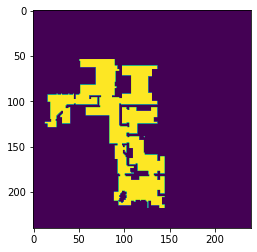

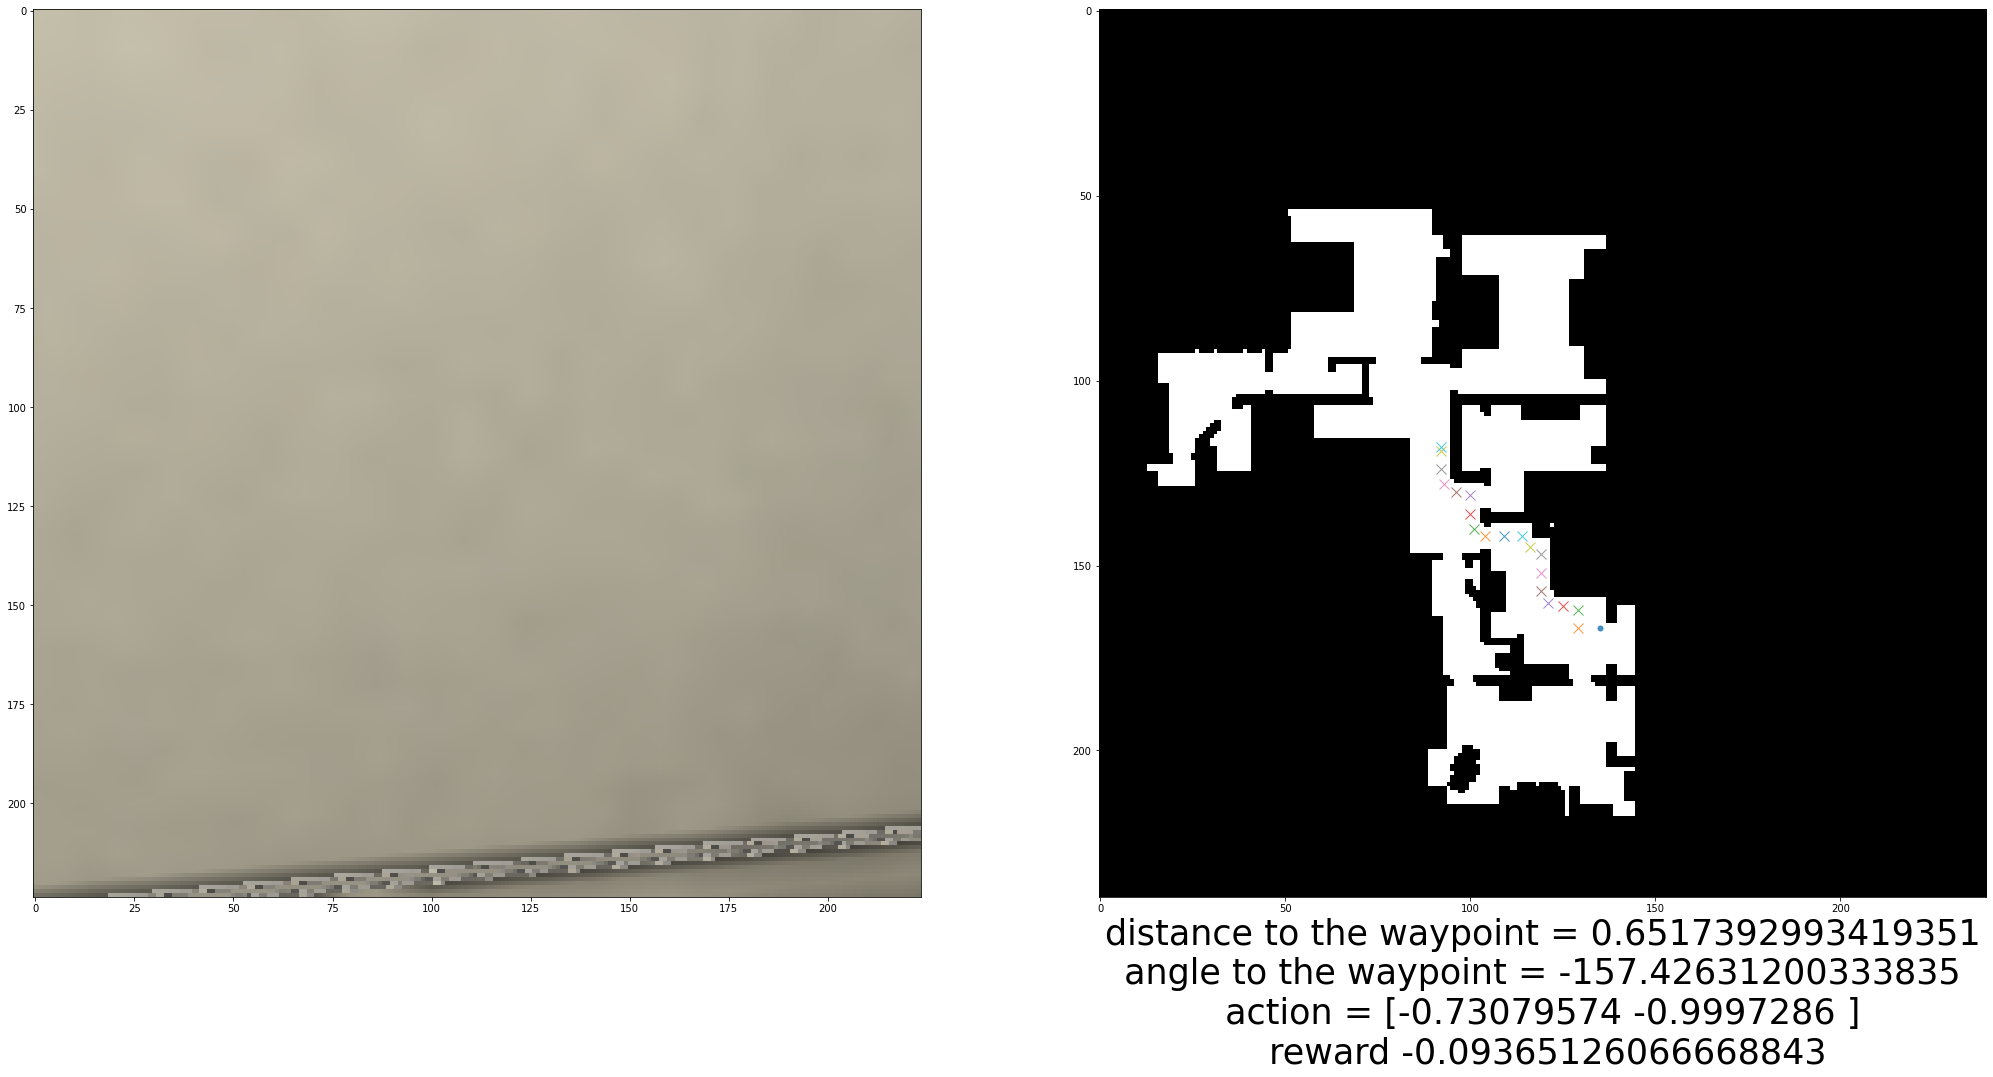

In [16]:
'''
EVALUATION
'''

state = env.reset()
#plt.imshow(state['rgb']);plt.show()
env.simulator.sync()

img_path = f'gibson2/data/gibson_challenge_data_2021/ig_dataset/scenes/{scene_id}/layout/floor_trav_0_new.png'
img = Image.open(img_path)
occupancy_grid = np.array(img)
occupancy_grid[occupancy_grid!=0] = 1
inflated_grid = inflate_grid(occupancy_grid, 2, 0, 0)
plt.imshow(occupancy_grid);plt.show()
waypoints = get_waypoints(scene_id, env)
waypoints_map = list(map(env.scene.world_to_seg_map, waypoints))
visualize_path(occupancy_grid, waypoints_map, show=True)

env.waypoints = waypoints
env.num_wps_input = args.num_wps_input

print("robot position", env.robots[0].get_position()[:-1])
print("target position", env.task.target_pos[:-1])
print("distance to the first waypoint", dist(env.robots[0].get_position()[:-1], env.waypoints[0]))

episode_reward = 0
done = False
total_distance = 0
avg_reward = 0
i = 0

run = 50
file_path = f'output_test_SAC/run{run}_deterministic_polar_potential0.1_orientation0.01_threshold0.1'
if not os.path.exists(file_path):
    os.mkdir(file_path)
    
import matplotlib
matplotlib.use('Agg')

while not done:
    #plt.figure()
    #plt.imshow(state['rgb'])
    obs = get_observation(env, state, scene_id, obs_encoder, mode="polar")
    
    robot_prev_pos = env.robots[0].get_position()[:-1]
    _,_,yaw = env.robots[0].get_rpy()
    #print("angle", np.degrees(yaw))
    robot_prev_pos_map = env.scene.world_to_seg_map(robot_prev_pos)
    waypoint_prev = env.waypoints[0]
    waypoint_prev_map = env.scene.world_to_seg_map(env.waypoints[0])
    
    action = agent.select_action(obs, evaluate=True)
    next_state, reward, done, info = env.step(action)
    episode_reward += reward
    
    # show rgb
    #plt.figure()
    #plt.imshow(state['rgb'])
    #plt.imshow(next_state['rgb']);
    #plt.savefig(f'output_test_SAC/run23_potentialweight0.01orientation0.001/rgb/{i}.jpg')
    #plt.show()
    #plt.close()
    
    robot_current_pos = env.robots[0].get_position()[:-1]
    robot_current_pos_map = env.scene.world_to_seg_map(robot_current_pos)
    waypoint_current_map = env.scene.world_to_seg_map(env.waypoints[0])
    
    waypoints = env.waypoints[:args.num_wps_input]
    waypoints = np.hstack((waypoints, np.zeros((len(waypoints),1))))
    waypoints_robot_coord = [env.task.global_to_local(env, p)[:2] for p in waypoints]
    # waypoints in polar coordinate in robot frame
    waypoints = [np.array(cartesian_to_polar(p[0],p[1])) for p in waypoints_robot_coord]
    wp = waypoints[0]
    
    d = dist(robot_current_pos, waypoint_prev)
    #print("reward", reward)
    #print("action", action)
    #print("distance to the waypoint", wp[0])
    #print("waypoints", env.waypoints)
    #total_distance += dist(robot_current_pos, robot_prev_pos)
    #print()
    
    s = f'distance to the waypoint = {wp[0]}\n angle to the waypoint = {np.degrees(wp[1])} \n action = {action} \n reward {reward}'
    
    # plot robot pos, waypoint pos on the map
    #plt.figure(figsize=[12,12])
    #plt.imshow(occupancy_grid, cmap='gray')
    #plt.plot(robot_current_pos_map[1],robot_current_pos_map[0],marker=".", markersize=5, alpha=0.8)
    #plt.xlabel(s)
    #plt.plot(robot_prev_pos_map[1],robot_prev_pos_map[0],marker="*", markersize=5, alpha=0.8)
    #plt.plot(waypoint_prev_map[1],waypoint_prev_map[0],marker="+", markersize=5, alpha=0.8)
    #plt.plot(waypoint_current_map[1],waypoint_current_map[0],marker="x", markersize=5, alpha=0.8)
    #plt.savefig(f'output_test_SAC/run23_potentialweight0.01orientation0.001/map/{i}.jpg')
    #plt.show()
    #plt.close()

    f, axarr = plt.subplots(1,2, figsize=(35, 35))
    axarr[0].imshow(state['rgb'])
    axarr[1].imshow(occupancy_grid, cmap='gray')
    axarr[1].plot(robot_current_pos_map[1],robot_current_pos_map[0],marker=".", markersize=10, alpha=0.8)
    axarr[1].set_xlabel(s, fontsize=35)
    
    waypoints_map = list(map(env.scene.world_to_seg_map, env.waypoints))
    for waypoint in waypoints_map:
        axarr[1].plot(waypoint[1],waypoint[0],marker="x", markersize=10, alpha=0.8)
    path = f'{file_path}/side_by_side'
    if not os.path.exists(path):
        os.mkdir(f'{file_path}/side_by_side')
    plt.savefig(f'{file_path}/side_by_side/{i}.jpg')
    plt.close()
    
    i += 1
    state = next_state
avg_reward += episode_reward
print(avg_reward)

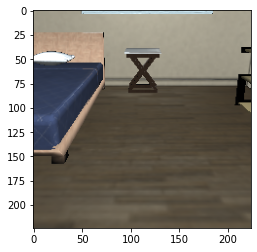

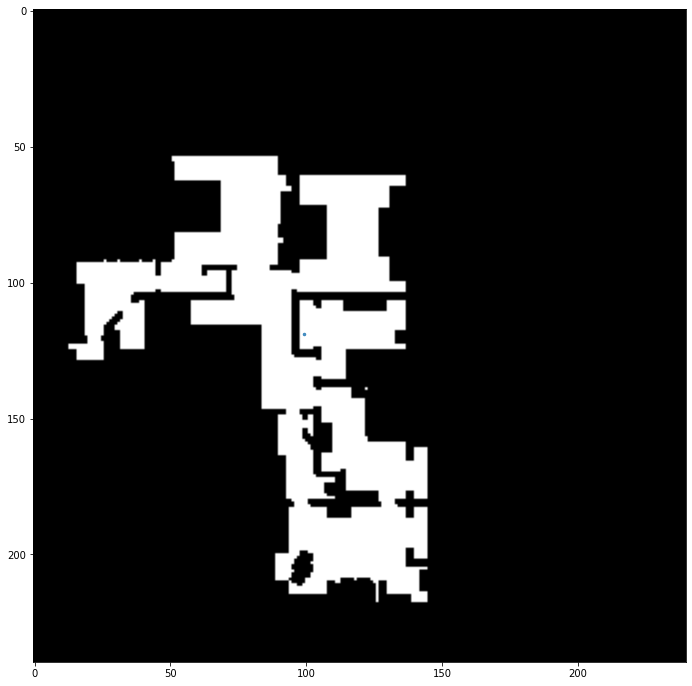

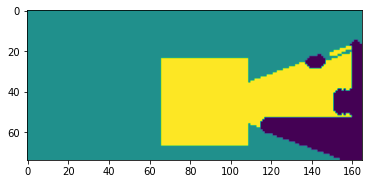

min_x_wf,max_x_wf,min_y_wf,max_y_wf,min_z_wf,max_z_wf -2.000444173812866 1.8064270472889992 -1.419999942125286 1.3661152273998605 -1.9063536105257128e-07 0.9438757439957526
min_x_rf,max_x_rf,min_y_rf,max_y_rf,min_z_rf,max_z_rf 0.0 3.8068712211018654 -1.4198417518637134 1.366273417661433 -0.020389291172065116 0.9234866434590485
action [-0.15923192  0.09983371]


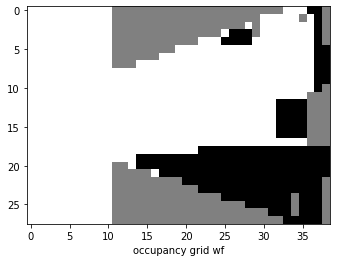

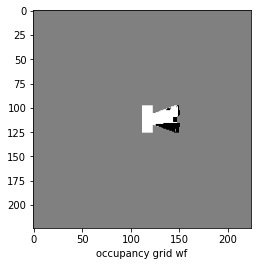

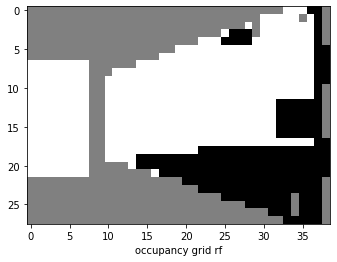

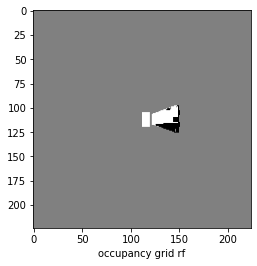

In [22]:
state = env.reset()
env.robots[0].set_position([-2,0,0])
env.robots[0].set_orientation([0,0,0,1])
#plt.imshow(state['rgb']);plt.show()
env.simulator.sync()
state = env.get_state()
img_path = f'gibson2/data/gibson_challenge_data_2021/ig_dataset/scenes/{scene_id}/layout/floor_trav_0_new.png'
img = Image.open(img_path)
occupancy_grid_gt = np.array(img)
occupancy_grid_gt[occupancy_grid_gt!=0] = 1
waypoints = get_waypoints(scene_id, env)
waypoints_map = list(map(env.scene.world_to_seg_map, waypoints))
#visualize_path(occupancy_grid_gt, waypoints_map, show=True)
env.waypoints = waypoints
env.num_wps_input = args.num_wps_input


i = 0
occupancy_grid_prev = None
robot_pos_prev_map = None
robot_position_wc_prev = None
while True:
    #print(f'i = {i}')
    #print(f"step threshold {step_threshold}")
    plt.figure();plt.imshow(state['rgb']);plt.show();
    robot_current_pos = env.robots[0].get_position()[:-1]
    robot_current_pos_map = env.scene.world_to_seg_map(robot_current_pos)
    
    plt.figure(figsize=[12,12])
    plt.imshow(occupancy_grid_gt, cmap='gray')
    plt.plot(robot_current_pos_map[1],robot_current_pos_map[0],marker=".", markersize=5, alpha=0.8)
    plt.show()

    # Get point clouds
    pc,_ = get_point_clouds(env, visualize=False)
    if i == 0:
        goal_wc = env.task.target_pos
        pc = np.vstack((pc, goal_wc))
        pc = np.vstack((pc, env.robots[0].get_position()))
        #print("goal", goal_wc)
        min_x,max_x,min_y,max_y,min_z,max_z = get_min_max_pcd(pc)
    else:
        min_x,max_x,min_y,max_y,min_z,max_z = get_min_max_pcd(pc,min_x,max_x,min_y,max_y,min_z,max_z)

    # Get partial map from current observation and inflate grid
    robot_position_wc = env.robots[0].get_position()
    occupancy_grid, robot_pos, goal_pos = \
        create_occupancy_grid([pc],min_x,max_x,min_y,max_y,min_z,max_z, \
                              robot_position_wc, goal_wc, RESOLUTION = 0.05, visualize=False, index=i, output_dir=None)
    occupancy_grid = inflate_grid(occupancy_grid, 2, 0, 0)
    #visualize_occupancy_grid(occupancy_grid, robot_pos[::-1], goal_pos[::-1], store=False, output_path=f'{out_dir}/inf_grid/{i}')

    # Make a global map observed so far using the current partial map and global map
    # Fill invisible cells close to the robot       
    prev_robot_pos_current_map = get_robot_pos_on_grid(robot_position_wc_prev, min_x, min_y, RESOLUTION = 0.05)
    occupancy_grid = update_map(occupancy_grid, occupancy_grid_prev, robot_pos_prev_map, prev_robot_pos_current_map)
    occupancy_grid = fill_invisible_cells_close_to_the_robot(occupancy_grid, robot_pos[1], robot_pos[0])
    plt.figure();plt.imshow(occupancy_grid); plt.show()
    #visualize_occupancy_grid(occupancy_grid, robot_pos[::-1], goal_pos[::-1], store=True, output_path=f'{out_dir}/global_map/{i}')

    # Store the current occupancy grid, robot positions on the map and wc for updating the map in the next iteraiton
    occupancy_grid_prev = occupancy_grid
    robot_pos_prev_map = robot_pos
    robot_position_wc_prev = robot_position_wc
    
    obs = get_observation(env, state, scene_id, obs_encoder)
    action = agent.select_action(obs, evaluate=True)
    print("action", action)

    next_state, reward, done, info = env.step([1,0])
    state = next_state
    
    break
    
    i+=1
    if i == 50:
        break

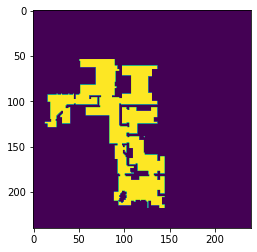

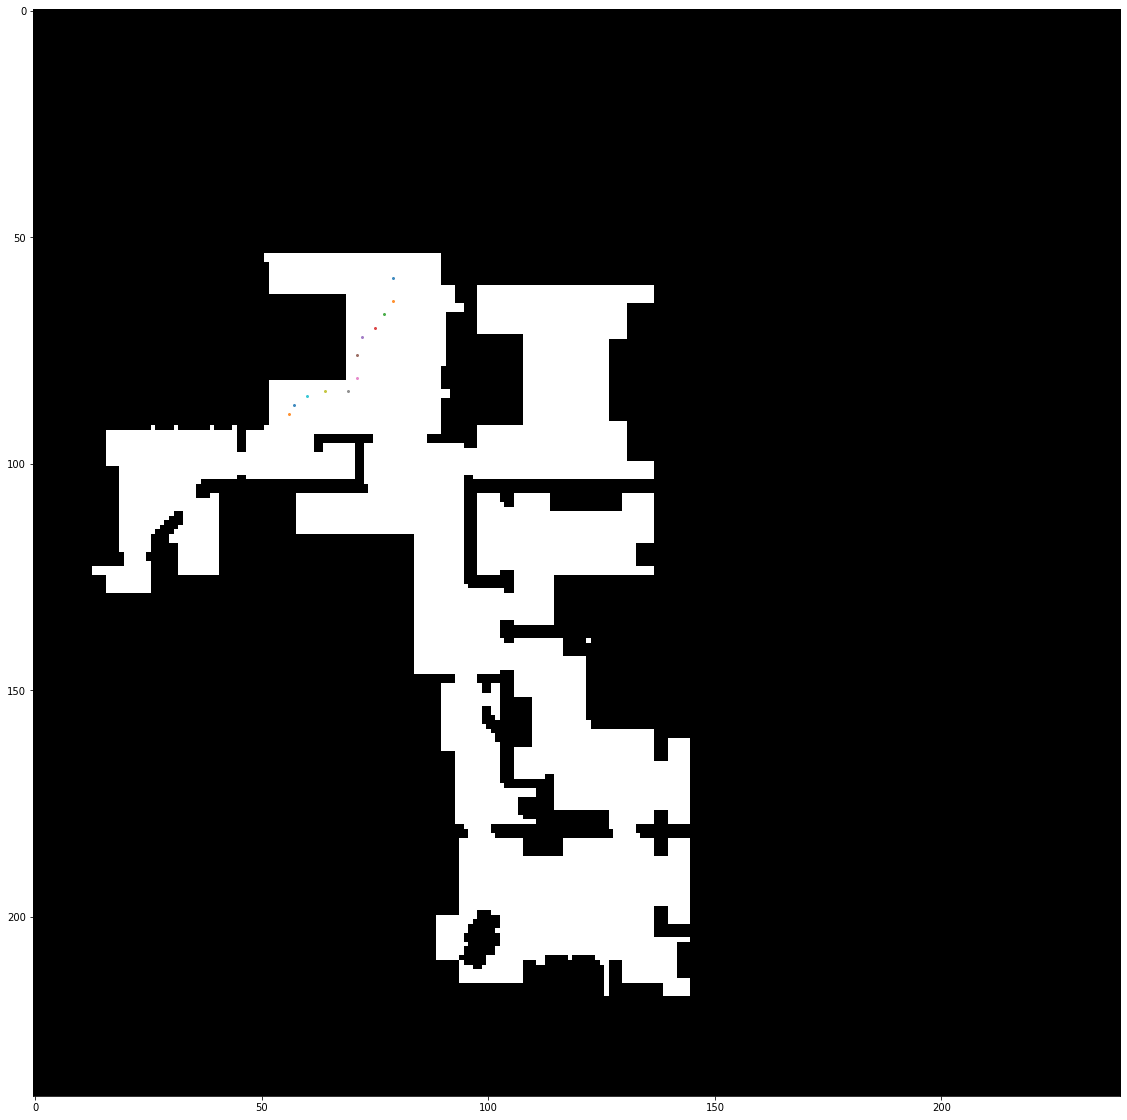

In [73]:
img_path = f'gibson2/data/gibson_challenge_data_2021/ig_dataset/scenes/{scene_id}/layout/floor_trav_0_new.png'
img = Image.open(img_path)
occupancy_grid = np.array(img)
occupancy_grid[occupancy_grid!=0] = 1
inflated_grid = inflate_grid(occupancy_grid, 2, 0, 0)
plt.imshow(occupancy_grid)
waypoints = get_waypoints(scene_id, env)
visualize_path(occupancy_grid, waypoints, show=True)

In [34]:
_,_,yaw = env.robots[0].get_rpy()
print("angle", np.degrees(yaw))

angle 0.06576453734305138


In [43]:
print(env.robots[0].get_position()[:-1])
print(env.task.target_pos[:-1])
source = env.scene.world_to_seg_map(env.robots[0].get_position()[:-1])
target = env.scene.world_to_seg_map(env.task.target_pos[:-1])
print(source)
print(target)
print(state['task_obs'])

[-3.09776402  1.40863264]
[-4.1 -1.7]
[134  89]
[103  79]
[ 3.25354125 -0.01431161 -0.15178465  0.0978807 ]


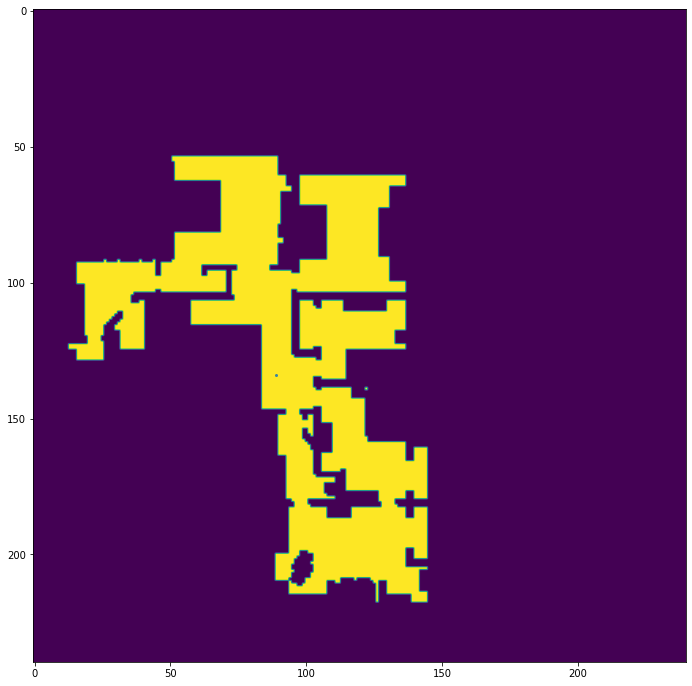

In [149]:
plt.figure(figsize=[12,12])
plt.imshow(occupancy_grid)
plt.plot(source[1],source[0],marker="o", markersize=2, alpha=0.8)
plt.show()

In [154]:
source = env.robots[0].get_position()[:-1]
print(source)

[ 0.01539318 -5.17710781]


[-0.17751527 -4.64685678]
0.5642515558813855


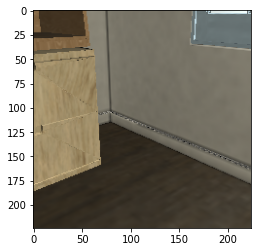

In [250]:
state,_,_,_ = env.step([1,0])
plt.imshow(state['rgb'])
print(env.robots[0].get_position()[:-1])
print(dist(source, env.robots[0].get_position()[:-1]))

In [254]:
print(env.robots[0].get_position()[:-1])
print(env.waypoints)
env.waypoints - env.robots[0].get_position()[:-1]

[-1.76808643 -2.3359437 ]
[array([-1.3, -2.6]), array([-1. , -2.8]), array([-0.9, -3.2]), array([-0.6, -3.4]), array([-0.4, -3.7]), array([-0.1, -3.9]), array([ 0.1, -4.2]), array([ 0.2, -4.2])]


array([[ 0.46808643, -0.2640563 ],
       [ 0.76808643, -0.4640563 ],
       [ 0.86808643, -0.8640563 ],
       [ 1.16808643, -1.0640563 ],
       [ 1.36808643, -1.3640563 ],
       [ 1.66808643, -1.5640563 ],
       [ 1.86808643, -1.8640563 ],
       [ 1.96808643, -1.8640563 ]])